# Superstore Sales Workflow Tutorial

This notebook walks through cleaning the Superstore dataset, designing a relational structure, creating an SQLite database, and running example SQL queries and visualizations.

In [1]:
%pip install pandas matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

## 1️) Load and Inspect the Dataset

In [3]:
# reading error codes + research is how you can learn if there is different encoding, as seen below
df = pd.read_csv('../data/Superstore.csv', encoding='ISO-8859-1')
df.head()
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='str')

### Double check some datatypes, and for nulls and duplicates:

In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   str    
 2   Order Date     9994 non-null   str    
 3   Ship Date      9994 non-null   str    
 4   Ship Mode      9994 non-null   str    
 5   Customer ID    9994 non-null   str    
 6   Customer Name  9994 non-null   str    
 7   Segment        9994 non-null   str    
 8   Country        9994 non-null   str    
 9   City           9994 non-null   str    
 10  State          9994 non-null   str    
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   str    
 13  Product ID     9994 non-null   str    
 14  Category       9994 non-null   str    
 15  Sub-Category   9994 non-null   str    
 16  Product Name   9994 non-null   str    
 17  Sales          9994 non-null   float64
 18  Quantity       9994

In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
df.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

This data is incredibly clean - we can see there are no null values and no duplicates. However, there are some dates that could be saved in a better format.

## 2) Data Cleaning

In [7]:
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)
df['Ship Date'] = pd.to_datetime(df['Ship Date'], dayfirst=True)

In [8]:
df.dtypes

Row ID                    int64
Order ID                    str
Order Date       datetime64[us]
Ship Date        datetime64[us]
Ship Mode                   str
Customer ID                 str
Customer Name               str
Segment                     str
Country                     str
City                        str
State                       str
Postal Code               int64
Region                      str
Product ID                  str
Category                    str
Sub-Category                str
Product Name                str
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

In [9]:
df.Segment.unique()

<StringArray>
['Consumer', 'Corporate', 'Home Office']
Length: 3, dtype: str

In [10]:
df.rename(columns={"Segment":"customer_category"}, inplace=True)
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,customer_category,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2013-152156,2013-11-09,2013-11-12,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2013-152156,2013-11-09,2013-11-12,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2013-138688,2013-06-13,2013-06-17,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2012-108966,2012-10-11,2012-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2012-108966,2012-10-11,2012-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


With real data, it is very likely more cleaning and wrangling would be required. 

## 3) Build Relational Tables

In [11]:
conn = sqlite3.connect('../data/superstore.db')

customers_df = df[['Customer ID','Customer Name','customer_category','City','State','Region', 'Postal Code']].drop_duplicates().rename(columns={
    'Customer ID':'customer_id',
    'Customer Name':'customer_name',
    'City':'city',
    'State':'state',
    'Region':'region',
    'Postal Code': 'postal_code'
})

products_df = df[['Product ID','Category','Sub-Category','Product Name']].drop_duplicates().rename(columns={
    'Product ID':'product_id',
    'Category':'category',
    'Sub-Category':'subcategory',
    'Product Name':'product_name'
})

orders_df = df[['Order ID','Order Date','Ship Date','Ship Mode','Customer ID']].drop_duplicates().rename(columns={
    'Order ID':'order_id',
    'Order Date':'order_date',
    'Ship Date':'ship_date',
    'Ship Mode':'ship_mode',
    'Customer ID':'customer_id'
})

order_details_df = df[['Order ID','Product ID','Sales','Quantity','Discount','Profit']].rename(columns={
    'Order ID':'order_id',
    'Product ID':'product_id'
})


customers_df.to_sql('customers', conn, index=False, if_exists='replace')
products_df.to_sql('products', conn, index=False, if_exists='replace')
orders_df.to_sql('orders', conn, index=False, if_exists='replace')
order_details_df.to_sql('order_details', conn, index=False, if_exists='replace')
conn.commit()

In [12]:
for name, df in [
    ('customers', customers_df),
    ("products", products_df),
    ("orders", orders_df),
    ("order_details", order_details_df)
]:
    df.to_csv(f'../data/{name}.csv')

## 4) Make Some Queries!

### Which customer segments bring in the most revenue and profit?

In [13]:
query1 = """ SELECT 
    c.customer_category,
    ROUND(SUM(od.sales), 2) AS total_sales,
    ROUND(SUM(od.profit), 2) AS total_profit
FROM order_details od
JOIN orders o ON od.order_id = o.order_id
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.customer_category
ORDER BY total_sales DESC;
"""
result1 = pd.read_sql(query1, conn)
result1

,customer_category,total_sales,total_profit
0,Consumer,8380282.43,973085.86
1,Corporate,5044899.83,660287.69
2,Home Office,2964459.36,434344.01


### What are the top 10 customers by total sales?

In [14]:
query2 = """ SELECT
c.customer_name,
ROUND(SUM(od.sales), 2) AS total_sales
FROM order_details od
JOIN orders o ON od.order_id = o.order_id
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.customer_id
ORDER BY total_sales DESC
LIMIT 10;
 """
result2 = pd.read_sql(query2, conn)
result2

,customer_name,total_sales
0,Ken Lonsdale,155927.52
1,Sanjit Engle,134303.82
2,Clay Ludtke,130566.55
3,Adrian Barton,130262.14
4,Sanjit Chand,127281.01
5,Sean Miller,125215.25
6,Edward Hooks,123730.56
7,Greg Tran,118201.20
8,Seth Vernon,114709.50
9,John Lee,107799.15


### Which product categories and subcategories are the most profitable overall?

In [40]:
query3 = """ SELECT
p.category,
p.subcategory,
ROUND(SUM(od.profit), 2) AS total_profit
FROM order_details od
JOIN orders o ON od.order_id = o.order_id
JOIN products p ON p.product_id = od.product_id
GROUP BY p.category, p.subcategory
ORDER BY total_profit DESC;
"""
result3 = pd.read_sql(query3, conn)
result3

,category,subcategory,total_profit
0,Technology,Copiers,"55,618"
1,Technology,Accessories,"48,359"
2,Technology,Phones,"46,936"
3,Office Supplies,Paper,"36,995"
4,Office Supplies,Binders,"30,373"
5,Furniture,Chairs,"26,708"
6,Office Supplies,Storage,"21,409"
7,Office Supplies,Appliances,"18,514"
8,Furniture,Furnishings,"14,570"
9,Office Supplies,Envelopes,"6,964"


### What is the average discount given per category?

In [16]:
query4 = """ 
SELECT
p.category,
AVG(od.Discount) as avg_discount
FROM order_details od
JOIN orders o ON od.order_id = o.order_id
JOIN products p ON p.product_id = od.product_id
GROUP BY p.category
ORDER BY avg_discount DESC;
"""
result4 = pd.read_sql(query4, conn)
result4

,category,avg_discount
0,Furniture,0.172514
1,Office Supplies,0.157000
2,Technology,0.132970


### Which states or regions contribute the most to total sales?

In [17]:
pd.options.display.float_format = '{:,.0f}'.format
query5 = """ SELECT
c.state,
sum(od.sales) as total_sales_per_state
FROM order_details od
JOIN orders o ON od.order_id = o.order_id
JOIN products p ON p.product_id = od.product_id
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.state
ORDER BY total_sales_per_state DESC
"""
result5 = pd.read_sql(query5, conn)
result5

,state,total_sales_per_state
0,California,"3,450,681"
1,New York,"1,952,520"
2,Texas,"1,629,680"
3,Pennsylvania,"917,134"
4,Washington,"899,203"
5,Illinois,"880,092"
6,Ohio,"745,708"
7,Florida,"663,912"
8,North Carolina,"459,672"
9,Michigan,"448,003"


### How many orders were shipped late (where Ship Date > Order Date + 3 days)?

In [86]:
query6 = """ 
SELECT
COUNT(*) as late_orders from orders 
WHERE julianday(ship_date) - julianday(order_date) > 3
"""
result6 = pd.read_sql(query6, conn)
result6

,late_orders
0,3391


### Which month or year had the highest total sales?

In [45]:
query7 = """ 
select strftime('%m', o.order_date) as Month, 
sum(od.Sales) as total_sales_per_month
FROM order_details od
JOIN orders o ON od.order_id = o.order_id
GROUP BY Month
order by total_sales_per_month desc

"""
result7 = pd.read_sql(query7, conn)
result7

,Month,total_sales_per_month
0,11,"349,120"
1,12,"332,177"
2,09,"309,770"
3,03,"199,253"
4,10,"197,115"
5,08,"159,589"
6,05,"156,122"
7,07,"149,581"
8,06,"147,083"
9,04,"141,852"


### What are the most frequently ordered products?

In [20]:
query8 = """ 
SELECT
p.product_name,
sum(quantity) as total_sold
from order_details od
JOIN orders o ON od.order_id = o.order_id
JOIN products p ON p.product_id = od.product_id
group by product_name
ORDER BY total_sold DESC
"""
result8 = pd.read_sql(query8, conn)
result8

,product_name,total_sold
0,Staples,876
1,Logitech P710e Mobile Speakerphone,75
2,Imation 16GB Mini TravelDrive USB 2.0 Flash Drive,75
3,KI Adjustable-Height Table,74
4,Storex Dura Pro Binders,71
...,...,...
1836,Xerox 20,1
1837,Penpower WorldCard Pro Card Scanner,1
1838,Global Enterprise Series Seating Low-Back Swiv...,1
1839,"Bush Saratoga Collection 5-Shelf Bookcase, Han...",1


### Which customers placed more than 5 orders total?

In [21]:
query9 = """ SELECT
c.customer_name,
count(o.order_id) as order_count
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
group by customer_name
order by order_count desc
 """
result9 = pd.read_sql(query9, conn)
result9

,customer_name,order_count
0,Emily Phan,289
1,Zuschuss Carroll,169
2,Sally Hughsby,169
3,Joel Eaton,169
4,Erin Ashbrook,169
...,...,...
788,Jocasta Rupert,1
789,Jenna Caffey,1
790,Carl Jackson,1
791,Anthony O'Donnell,1


### What’s the profit margin (profit ÷ sales) by category or customer type?

In [34]:
query10 = """  SELECT
c.customer_category,
sum(od.profit) as total_profit,
sum(od.sales) as total_sales,
sum(cast(od.profit as real))/sum(cast(od.sales as real))*100 as profit_margin
from order_details od
JOIN orders o ON od.order_id = o.order_id
JOIN customers c ON o.customer_id = c.customer_id
group by customer_category
order by profit_margin desc 
"""
result10 = pd.read_sql(query10, conn)
result10

,customer_category,total_profit,total_sales,profit_margin
0,Home Office,"434,344","2,964,459",15
1,Corporate,"660,288","5,044,900",13
2,Consumer,"973,086","8,380,282",12


### 5) Visualize it!

From your ten results, select at least 4 to utilize in a meaningful visualization. 

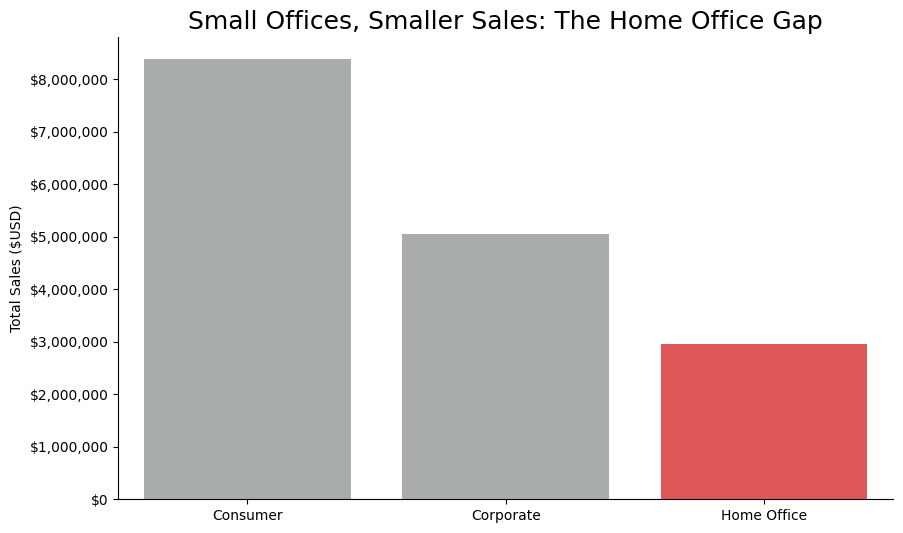

In [32]:
# example using result1
plt.figure(figsize=(10,6))
colors = ["#a7adaa", "#a7adaa", "#f74141" ]
sns.barplot(result1, x='customer_category', y='total_sales', palette=colors, hue='customer_category', legend=False)
plt.title('Small Offices, Smaller Sales: The Home Office Gap',fontsize=18)
plt.xlabel(None)
plt.ylabel('Total Sales ($USD)')

#for those wondering how to get rid of scientific notation! Set style to plain:
plt.ticklabel_format(style='plain', axis='y')

#mticker is a great library for helping tick mark formatting, such as adding commas and dollar signs in this case
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

#using the seaborn library, despining is way easier!
sns.despine()
plt.show()


In [70]:
result3
profitable_products = result3['total_profit']>0
profitable_products

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14    False
15    False
16    False
Name: total_profit, dtype: bool

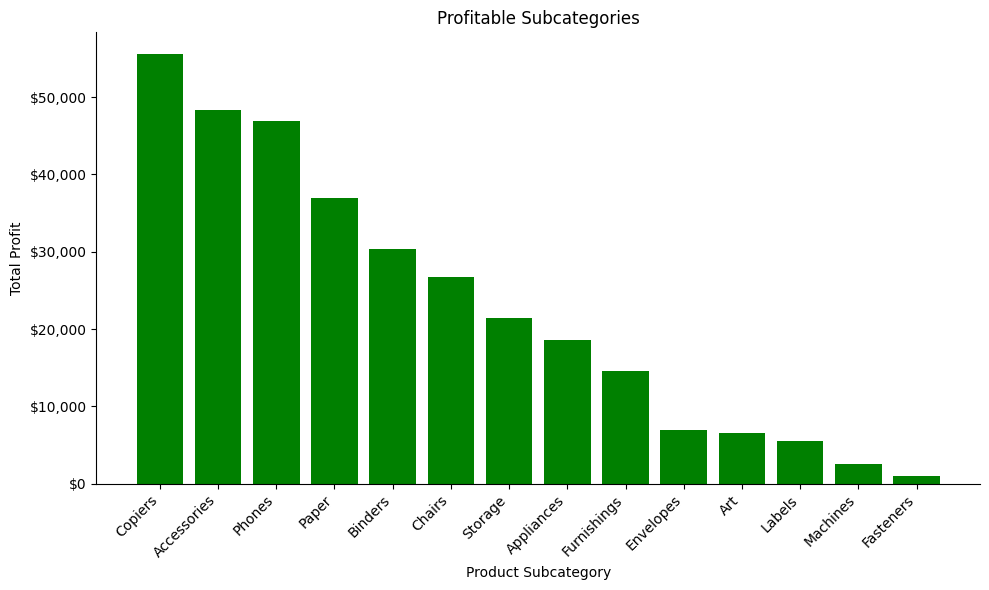

In [81]:
# visualization one code here
#Which product categories and subcategories are the most profitable overall?
result3
profitable_products = result3[result3['total_profit']>0]
plt.figure(figsize=(10,6))
plt.bar(profitable_products.subcategory.values,profitable_products.total_profit, color="green")

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel("Product Subcategory")
plt.ylabel("Total Profit")
plt.title("Profitable Subcategories")
plt.xticks(rotation=45, ha="right")
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

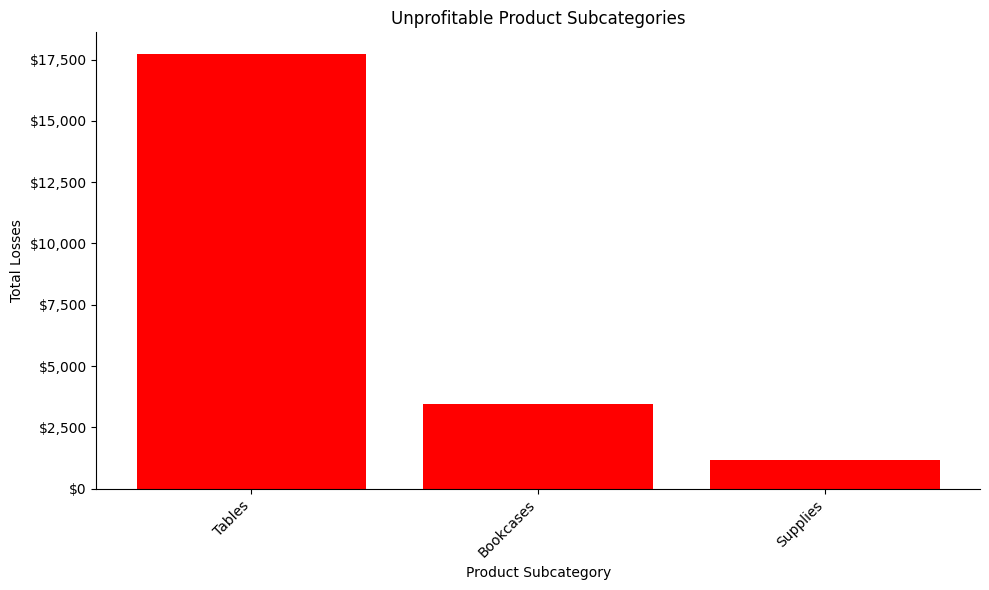

In [126]:
# visualization two code here
#Which month or year had the highest total sales?
result3
unprofitable_products = result3[result3['total_profit']<0]
unprofitable_products['losses'] = unprofitable_products['total_profit']*-1
uprofitable_products=unprofitable_products.sort_values(by='losses', ascending=False)
plt.figure(figsize=(10,6))
plt.bar(uprofitable_products.subcategory.values,uprofitable_products.losses, color="red")

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel("Product Subcategory")
plt.ylabel("Total Losses")
plt.title("Unprofitable Product Subcategories")
plt.xticks(rotation=45, ha="right")
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

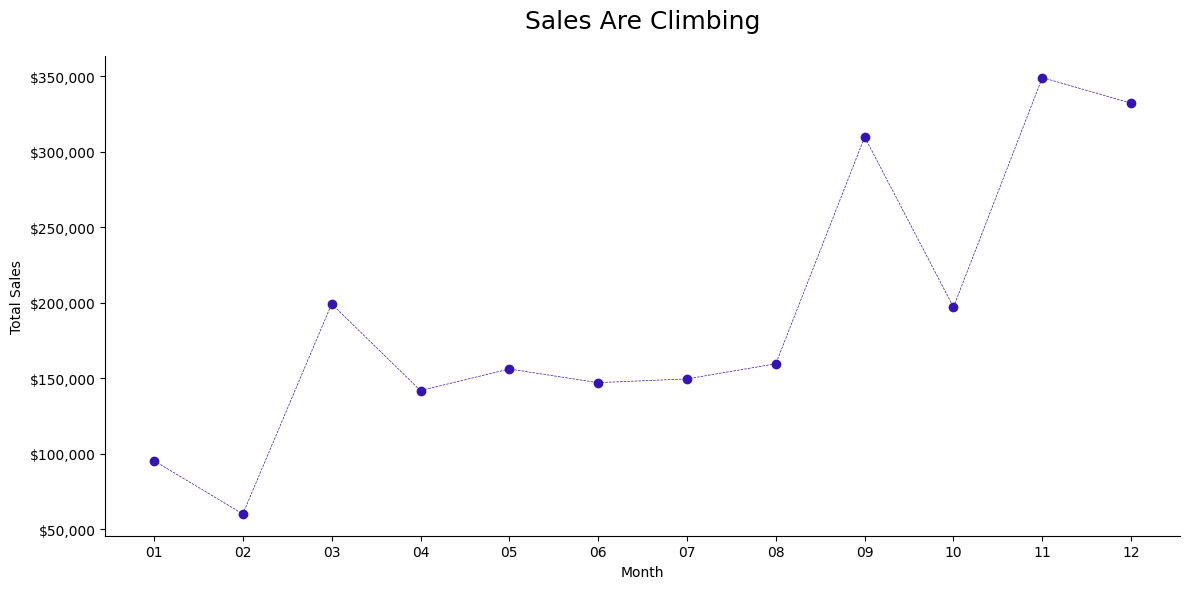

In [121]:
# visualization three code here
#Which month or year had the highest total sales?
result7 = result7.sort_values(by='Month')
plt.figure(figsize=(12,6))
plt.plot(
    result7.Month,
    result7.total_sales_per_month,
    marker="o",
    linestyle = "--",
    color = "#3614B3",
    linewidth = 0.5
    )
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.title("Sales Are Climbing", fontsize = 18, pad = 20)

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

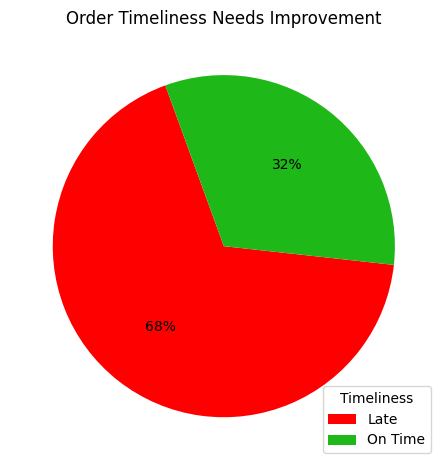

In [122]:
# visualization four code here
total_orders=5009
late_orders=result6['late_orders'][0]
late_df = pd.DataFrame({'Timeliness':['Late','On Time'],'Number':[late_orders,total_orders-late_orders]})

plt.pie(
    late_df['Number'],
    labels=None,
    startangle=110,
    colors=["red","#1eb819"],
    autopct="%1.0f%%"
    )
plt.title("Order Timeliness Needs Improvement")
plt.legend(
    labels = late_df['Timeliness'],
    loc="lower right",
    title = "Timeliness"
)

plt.tight_layout()
plt.show()

